In [4]:
%run ../utils/common.py
import networkx as nx

In [2]:
community_categories={}
with open("../data/categories_splitted_into_communities.json", "r") as f_in:
    for line in f_in:
        json_line=json.loads(line)
        community_categories[json_line['community_id']]=json_line['categories']

In [7]:
community_categories[23]

['Buildings_and_structures_in_Campinas',
 'Music_venues_completed_in_1886',
 'Music_venues_in_Montreal',
 "UC_Riverside_Highlanders_women's_volleyball",
 'Olympic_freestyle_skiing_venues',
 'Shopping_malls_in_Omaha,_Nebraska',
 'Casinos_completed_in_1994',
 'Shopping_malls_in_Kern_County,_California',
 'Music_venues_in_Ottawa',
 'Theatres_in_Sofia',
 'Theatres_in_Brooklyn',
 'Skyscrapers_in_Lisbon',
 'Bosnian-American_culture_in_Missouri',
 'South_Park_(Downtown_Los_Angeles)',
 'Theatres_in_the_Bronx',
 'Cleveland_Browns_stadiums',
 'Gymnastics_venues_in_California',
 'Wrestling_venues_in_California',
 'Theatre_companies_in_Pittsburgh',
 'Waterhead,_Greater_Manchester',
 'Sports_venues_in_Fukushima_Prefecture',
 'Sports_venues_in_Nagano_Prefecture',
 'Sports_venues_in_Gunma_Prefecture',
 'Velodromes_in_Switzerland',
 'Barra_Olympic_Park',
 'Ski_areas_and_resorts_in_France',
 'Music_venues_completed_in_1899',
 'Soccer_venues_in_Los_Angeles',
 'Basketball_venues_in_Italy',
 'Geography_of

In [5]:
articles_categories_file="../data/article_categories_no_unknown_types.tsv"
wcnoutput_file="../data/gini_articles_scores_0985_no_unknown_type.json"

# we get the set of article ids which have at least one section after filtering out unique sections
articles_with_sections=set(load_json("../data/article_sections_filtered.json", object_hook=article_sections_object_hook).keys())

# while in memory, we use category ids insead of their titles to save space (because the same category appears multiple times)
category_title_to_id_map=get_category_title_to_id_map()
category_id_to_title_map={v:k for k,v in category_title_to_id_map.items()}

# we ignore "container categories" ie categories which are supposed to contain only subcategories
# in the dataset from March 2021, there is one article in the category "Births" which is supposed to be a container category
container_categories=set()
with open("../data/category_graph.tsv", encoding="utf8") as f:
    for line in f:
        split_line = line.split()
        category=split_line[0]
        parent_category=split_line[1]
        if parent_category=="Container_categories":
            container_categories.add(category_title_to_id_map[category])

# we ignore categories which are not ontologically pure enough, because these will not provide sections for recommendation
pure_categories=set()
with open(wcnoutput_file, encoding="utf8") as f:
    for line in f:
        line_dict = json.loads(line)
        category = line_dict['category']
        category_id=category_title_to_id_map[category]
        pure_categories.add(category_id)
        articles=line_dict['articles']


# key: article id, value: list of categories
article_categories={}
with open(articles_categories_file, encoding="utf8") as f:
    for line in f:
        split_line = line.split()
        article_id = int(split_line[0])
        if article_id not in articles_with_sections:
            continue
        category = split_line[2]
        category_id=category_title_to_id_map[category]
        if category_id not in pure_categories:
            continue
        if category_id in container_categories:
            continue
        if article_id not in article_categories.keys():
            article_categories[article_id]=[]
        article_categories[article_id].append(category_id)

In [6]:
# key: category id, value: set of articles which belongs to this category
category_articles={}
for article,categories in tqdm(article_categories.items()):
    for category_id in categories:
        if category_id not in category_articles.keys():
            category_articles[category_id]=set()
        category_articles[category_id].add(article)

  0%|          | 0/1737697 [00:00<?, ?it/s]

In [10]:
def build_graph(categories,category_articles_dict,article_categories_dict):
    
    g=nx.Graph()

    # get set of all articles which belongs to at least one category in the current connected component/community
    articles_belonging_at_least_to_one_category=set().union(*[category_articles_dict[category_id] for category_id in categories])
    for article_id in articles_belonging_at_least_to_one_category:
        categories_to_connect_in_graph=[category_id for category_id in article_categories_dict[article_id] if category_id in categories]
        if len(categories_to_connect_in_graph)==1:
            g.add_node(categories_to_connect_in_graph[0])
        else:
            for i in range(len(categories_to_connect_in_graph)):
                for j in range(i+1,len(categories_to_connect_in_graph)):
                    catA=categories_to_connect_in_graph[i]
                    catB=categories_to_connect_in_graph[j]
                    if not g.get_edge_data(catA,catB):
                        g.add_edge(catA,catB,weight=1)
                    else:
                        old_weight=g.get_edge_data(catA,catB)['weight']
                        g.get_edge_data(catA,catB)['weight']=old_weight+1
    
    # normalize weights
    for edge in g.edges:
        catA=edge[0]
        catB=edge[1]
        old_weight=g.get_edge_data(catA,catB)['weight']
        n=len(category_articles_dict[catA].union(category_articles_dict[catB]))
        # probability that a randomly picked article in either catA or catB belongs to both categories
        g.get_edge_data(catA,catB)['weight']=old_weight/n
        
    return g

In [11]:
category_ids=[category_title_to_id_map[category] for category in  community_categories[23]]

In [41]:
g=build_graph(category_ids,category_articles,article_categories)

In [2]:
import matplotlib.pyplot as plt

def plot_graph(g,margins=0.5,font_color="red",node_color="white",relabel_categories=False,swap_pos=None,round_decimals=4,node_size=2000,spring_layout=False):
    if relabel_categories:
        g_to_plot=nx.relabel_nodes(g,category_id_to_title_map)
    else:
        g_to_plot=g.copy()
    plt.figure(figsize=(14,8))
    plt.margins(margins)
    if spring_layout:
        pos=nx.spring_layout(g_to_plot)
    else:
        pos = nx.circular_layout(g_to_plot)
    if swap_pos:
        for node_A,node_B in swap_pos.items():
            pos[node_A],pos[node_B]=pos[node_B],pos[node_A]
    nx.draw(g_to_plot,pos,with_labels=True,node_color=node_color,font_color=font_color,node_size=node_size)
    labels = nx.get_edge_attributes(g_to_plot,'weight')
    labels={(cat_A,cat_B):round(weight,round_decimals) for (cat_A,cat_B),weight in labels.items()}
    nx.draw_networkx_edge_labels(g_to_plot,pos,edge_labels=labels)
    


In [43]:
categories_to_plot=['Detroit_Red_Wings_arenas','Indoor_ice_hockey_venues_in_Detroit']

In [44]:
category_ids_to_plot=[category_title_to_id_map[category] for category in  categories_to_plot]

In [45]:
import random

In [46]:
category_ids_to_keep_in_graph=set()
for category_id_to_plot in category_ids_to_plot:
    category_ids_to_keep_in_graph.add(category_id_to_plot)
    for category_id in g.neighbors(category_id_to_plot):
        if random.random()<0.035:
            category_ids_to_keep_in_graph.add(category_id)

In [47]:
len(category_ids_to_keep_in_graph)

3

In [48]:
for category_id_to_remove in set(g.nodes)-category_ids_to_keep_in_graph:
    g.remove_node(category_id_to_remove)

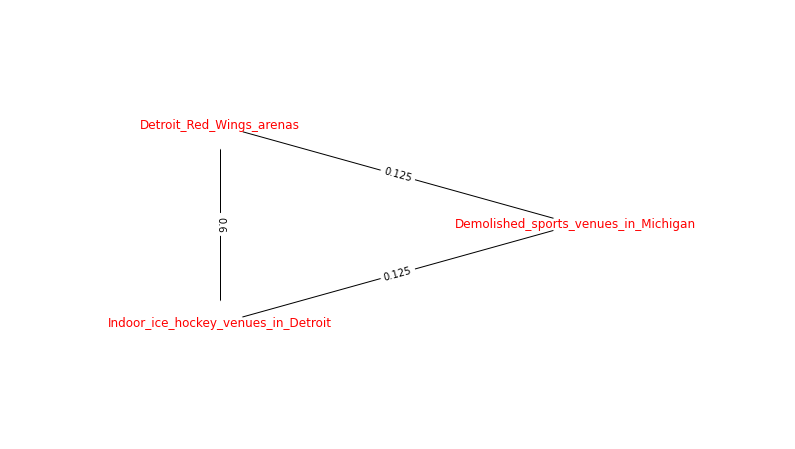

In [49]:
plot_graph(g,relabel_categories=True)

In [39]:
similar_sections_g=nx.read_edgelist("../data/example_similar_section_graphs/1",nodetype=str)

In [40]:
similar_sections_g1=nx.Graph()
similar_sections_g2=nx.Graph()
for i,nodes in enumerate(nx.connected_components(similar_sections_g)):
    
    for A,B in similar_sections_g.edges:
        if A in nodes and B in nodes:
            if i==0:
                similar_sections_g1.add_edge(A,B,weight=similar_sections_g.get_edge_data(A,B)['weight'])
            else:
                similar_sections_g2.add_edge(A,B,weight=similar_sections_g.get_edge_data(A,B)['weight'])

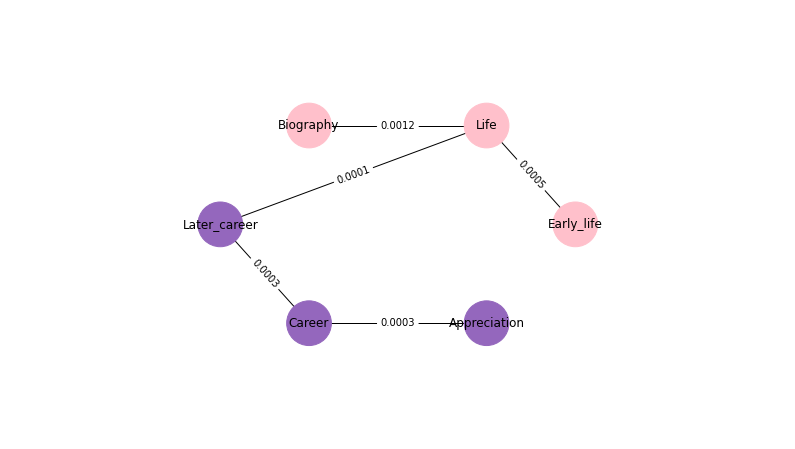

In [41]:
#if we take the best louvain partition, these 2 communities would be merged, if we take the first partition, they are separated
node_color_map={"Life":"pink",
                "Early_life":"pink",
                "Biography":"pink",
                "Later_career":"tab:purple",
                "Career":"tab:purple",
                "Appreciation":"tab:purple"}
plot_graph(similar_sections_g1,margins=0.5,font_color="black",node_color=[node_color_map[node] for node in similar_sections_g1.nodes])

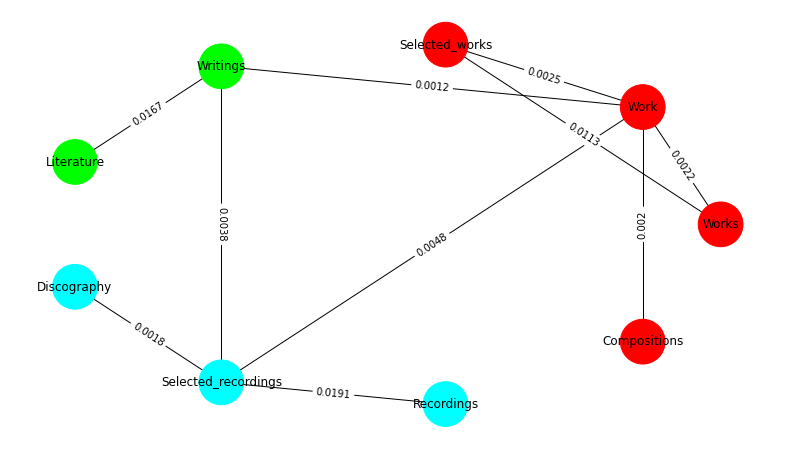

In [42]:
node_color_map={"Selected_works":"red",
                "Work":"red",
                "Works":"red",
                "Compositions":"red",
                "Literature":"lime",
                "Writings":"lime",
               "Recordings":"cyan",
               "Selected_recordings":"cyan",
               "Discography":"cyan"}
plot_graph(similar_sections_g2,margins=0.05,font_color="black",node_color=[node_color_map[node] for node in similar_sections_g2.nodes],swap_pos={'Compositions':'Discography','Literature':'Selected_recordings'})

In [44]:
same_article_probability_g=nx.read_edgelist("../data/example_similar_section_graphs/2",nodetype=str)

In [45]:
nodes_to_keep=set(['Demographics','Economy','Sports','Media'])
neighbor_nodes_to_keep=set()
for section_A,section_B in same_article_probability_g.edges():
    if section_A not in nodes_to_keep or section_B not in nodes_to_keep:# or (len(set([section_A,section_B]).intersection(nodes_to_keep))==1 and random.random()<0.5):
        same_article_probability_g.remove_edge(section_A,section_B)
    else:
        neighbor_nodes_to_keep.add(section_A)
        neighbor_nodes_to_keep.add(section_B)
for node in set(same_article_probability_g.nodes)-neighbor_nodes_to_keep:
    same_article_probability_g.remove_node(node)

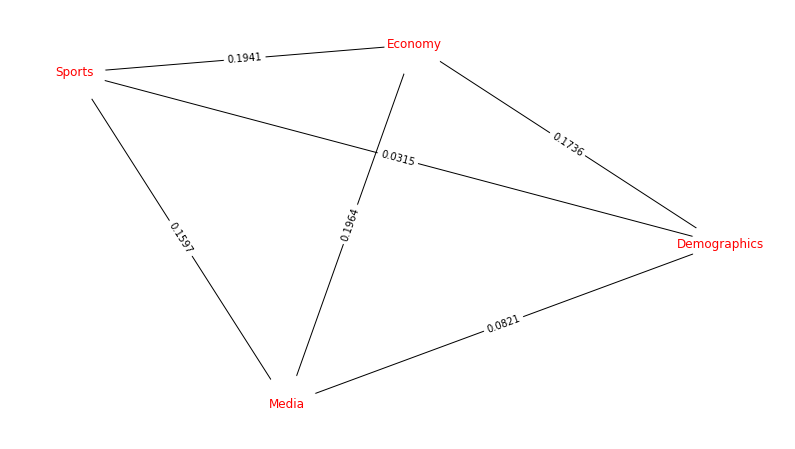

In [47]:

plot_graph(same_article_probability_g,margins=0.05,node_size=3500,spring_layout=True)

In [7]:
example_g=nx.Graph()
example_g.add_edge("A","B")
example_g.add_edge("A","C")
example_g.add_edge("A","D")
example_g.add_edge("C","E")
example_g.add_edge("C","F")

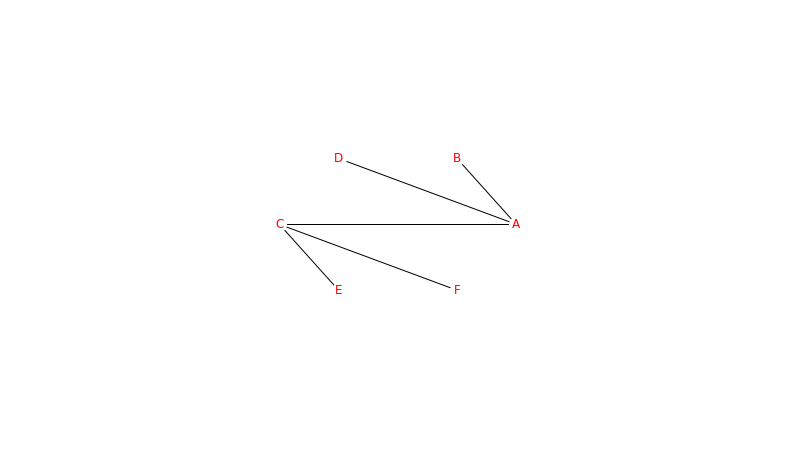

In [10]:
plot_graph(example_g,node_size=200,margins=1,swap_pos={'C':'D'})

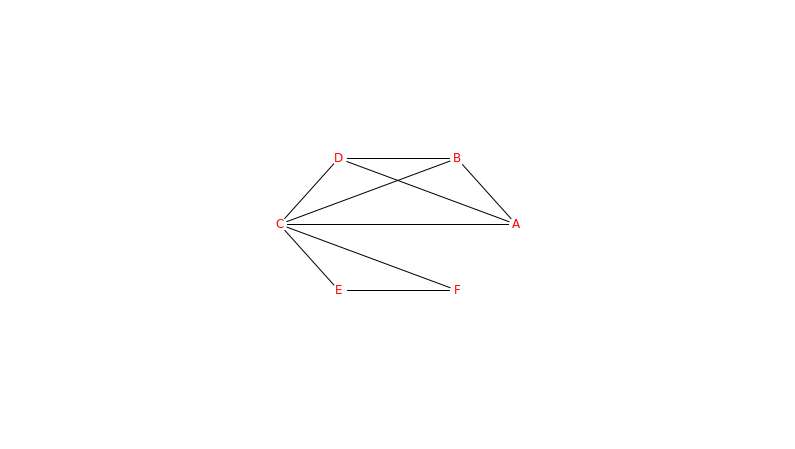

In [14]:
example_g2=nx.complete_graph(4)
example_g2=nx.relabel_nodes(example_g2,{0:'A',1:'B',2:'C',3:'D'})
example_g2.add_edge("C","E")
example_g2.add_edge("C","F")
example_g2.add_edge("E","F")
plot_graph(example_g2,node_size=200,margins=1,swap_pos={'C':'D'})